# How to work with Climate Adaptation Digital Twin data on Earth Data Hub: fields on a single level or surface, standard resolution

***
This notebook will provide you guidance on how to access and use the `SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr` datset on Earth Data Hub. This is a sample dataset for the Destine Climate Adaptation Digital Twin, fields on a single level or surface, standard resolution.

Our first goal is to plot the mean 2 metre temperature in January 2029 over Central Europe.

Our second goal is to compute the 2 metre temperature climatology (monthly means and standard deviations) in Berlin for the 2020-2028 reference period.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

# your `~/.netrc` file MUST contain your credentials for earthdatahub.com
#
# machine data.earthdatahub.com
#   login {your_username}
#   password {your_password}

ds = xr.open_dataset(
    "https://data.earthdatahub.com/destine-climate-dt/SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr",
    chunks={},
    engine="zarr",
    storage_options={"client_kwargs": {"trust_env": True}},
)
ds

<xarray.Dataset> Size: 3TB
Dimensions:    (time: 84936, latitude: 512, longitude: 1025)
Coordinates:
  * latitude   (latitude) float64 4kB -90.0 -89.65 -89.3 ... 89.3 89.65 90.0
  * longitude  (longitude) float64 8kB -180.0 -179.6 -179.3 ... 179.6 180.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 679kB 2020-01-01 ... 2029-09-08T23:00:00
Data variables: (12/18)
    blh        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    chnk       (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    hcc        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    lcc        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    mcc        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    ...         ...
    tciw       (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    tclw       (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    tprate     (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 178GB dask.array<chunksize=(576, 128, 128), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-03-27T16:00 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## 2 metre temperature: average January 2030 in Germany

### 1. Data selection

First, we perform a geographical selection corresponding to the Germany area. This greatly reduces the amount of data that will be downloaded from EDH. Also, we convert the temperature to `°C`.

In [2]:
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"
t2m_germany_area = t2m.sel(**{"latitude": slice(47, 55), "longitude": slice(5, 16)})
t2m_germany_area

<xarray.DataArray 't2m' (time: 84936, latitude: 23, longitude: 31)> Size: 242MB
dask.array<getitem, shape=(84936, 23, 31), dtype=float32, chunksize=(576, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 679kB 2020-01-01 ... 2029-09-08T23:00:00
Attributes:
    units:    C

!NB: At this point, no data has been downloaded yet, nor loaded in memory.

Second, we further select January 2030. This is again a lazy operation:

In [3]:
t2m_germany_area_january_2029 = t2m_germany_area.sel(time="2029-01")
t2m_germany_area_january_2029

<xarray.DataArray 't2m' (time: 744, latitude: 23, longitude: 31)> Size: 2MB
dask.array<getitem, shape=(744, 23, 31), dtype=float32, chunksize=(576, 23, 31), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 6kB 2029-01-01 ... 2029-01-31T23:00:00
Attributes:
    units:    C

At this point the selection is small enough to call `.compute()` on it. This will trigger the download of data from EDH and load it in memory. 

We can measure the time it takes:

In [4]:
%%time

t2m_germany_area_january_2029 = t2m_germany_area_january_2029.compute()

CPU times: user 347 ms, sys: 111 ms, total: 457 ms
Wall time: 2.38 s


The data was very small, this didn't take long.

### 2. Data reduction

Now that the data is loaded in memory, we can easily compute the october 2023 monthly mean:

In [5]:
t2m_germany_area_january_2029_monthly_mean = t2m_germany_area_january_2029.mean(dim="time")
t2m_germany_area_january_2029_monthly_mean

<xarray.DataArray 't2m' (latitude: 23, longitude: 31)> Size: 3kB
array([[  0.8268195 ,   0.09562966,   0.09562966,  -3.8670323 ,
         -3.8670323 ,  -2.5228074 ,  -3.5523639 ,  -2.8270624 ,
         -3.8984482 ,  -3.8984482 ,  -6.6064262 ,  -6.6064262 ,
         -6.9159017 ,  -6.9159017 ,  -8.400274  ,  -8.400274  ,
         -7.151115  , -10.230579  , -10.230579  , -13.541682  ,
        -13.541682  , -10.364821  , -10.364821  , -10.120367  ,
        -10.120367  ,  -8.356088  ,  -6.50211   ,  -6.50211   ,
         -4.9821258 ,  -4.9821258 ,  -4.9779267 ],
       [  0.2061889 ,  -0.8942958 ,  -0.8942958 ,  -2.5228074 ,
         -2.5228074 ,  -2.5228074 ,  -2.8270624 ,  -2.8270624 ,
         -3.317822  ,  -3.317822  ,  -4.2306128 ,  -4.2306128 ,
         -4.260681  ,  -4.260681  ,  -4.260681  ,  -7.151115  ,
         -7.151115  ,  -9.006288  ,  -9.006288  ,  -7.145067  ,
         -7.145067  ,  -6.7220182 ,  -6.7220182 ,  -6.7220182 ,
         -8.356088  ,  -8.356088  , -10.770062  , -10.770062  ,
         -7.411884  ,  -7.411884  ,  -5.1691194 ],
       [ -1.1442963 ,  -0.71485734,  -0.71485734,  -0.71485734,
         -2.2088182 ,  -2.2088182 ,  -2.020643  ,  -2.020643  ,
         -3.4698687 ,  -3.4698687 ,  -4.2306128 ,  -2.6147106 ,
         -2.6147106 ,  -4.632325  ,  -4.632325  ,  -5.7257338 ,
...
         -4.231622  ,  -6.28235   ,  -6.28235   ,  -4.3532615 ,
         -6.695319  ,  -6.695319  ,  -5.5671306 ,  -7.2594986 ,
         -5.508161  ,  -5.7853765 ,  -5.7853765 ,  -4.0689907 ,
         -8.352406  ,  -8.352406  ,  -4.604267  ],
       [  0.9474251 ,   0.9360005 ,   0.33386144,   0.33386144,
         -0.5754095 ,  -0.5754095 ,  -0.86606836,  -1.8267617 ,
         -1.8267617 ,  -2.3183575 ,  -4.3583007 ,  -4.3583007 ,
         -4.8230147 ,  -4.8230147 ,  -3.8344545 ,  -4.231622  ,
         -4.231622  ,  -3.300531  ,  -4.3532615 ,  -4.3532615 ,
         -5.5671306 ,  -5.5671306 ,  -2.9315898 ,  -5.508161  ,
         -5.508161  ,  -2.6621048 ,  -4.0689907 ,  -4.0689907 ,
         -4.604267  ,  -4.604267  ,  -2.8569965 ],
       [  0.9360005 ,   0.9057586 ,   0.24078386,   0.24078386,
         -0.86606836,  -0.86606836,  -0.86606836,  -2.3183575 ,
         -2.3183575 ,  -2.2531672 ,  -4.0898266 ,  -4.0898266 ,
         -3.8344545 ,  -3.8344545 ,  -3.8344545 ,  -3.300531  ,
         -3.300531  ,  -3.300531  ,  -4.407364  ,  -4.407364  ,
         -4.425849  ,  -2.9315898 ,  -2.9315898 ,  -2.6621048 ,
         -2.6621048 ,  -2.6621048 ,  -2.3889196 ,  -2.3889196 ,
         -4.4621344 ,  -2.8569965 ,  -2.8569965 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 184B 47.03 47.38 47.73 ... 54.07 54.42 54.77
  * longitude  (longitude) float64 248B 5.273 5.625 5.977 ... 15.12 15.47 15.82
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0

## 3. Visualization
Finally, we can plot the january 2029 monthly mean on a map:

In [6]:
import display
import matplotlib.pyplot as plt

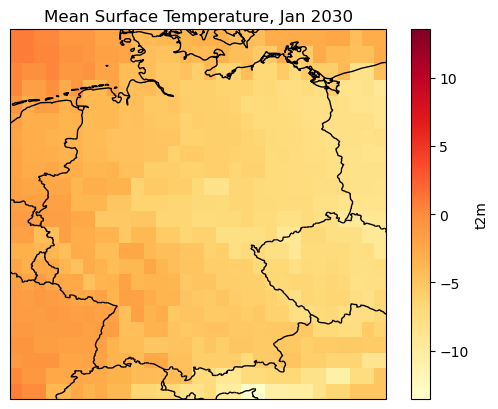

In [7]:
display.map(t2m_germany_area_january_2029_monthly_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Jan 2030")

## 2020-2028 climatology

We will now compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin for the reference period 2020-2028.

We first select the closet data to Berlin:

In [8]:
%%time

t2m_Berlin_2020_2028 = t2m.sel(**{"latitude": 52.5, "longitude": 13.4}, method="nearest").sel(time=slice("2020", "2028"))
t2m_Berlin_2020_2028

CPU times: user 5.24 ms, sys: 1.22 ms, total: 6.46 ms
Wall time: 4.85 ms


<xarray.DataArray 't2m' (time: 78912)> Size: 316kB
dask.array<getitem, shape=(78912,), dtype=float32, chunksize=(576,), chunktype=numpy.ndarray>
Coordinates:
    latitude   float64 8B 52.66
    longitude  float64 8B 13.36
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 631kB 2020-01-01 ... 2028-12-31T23:00:00
Attributes:
    units:    C

This is already small enought to be computed:

In [9]:
%%time

t2m_Berlin_2020_2028 = t2m_Berlin_2020_2028.compute()

CPU times: user 19.2 s, sys: 4.72 s, total: 23.9 s
Wall time: 2min 13s


Now that the data is loaded in memory we can easily compute the climatology:

In [10]:
t2m_Berlin_climatology_mean = t2m_Berlin_2020_2028.groupby("time.month").mean(dim="time")
t2m_Berlin_climatology_std = t2m_Berlin_2020_2028.groupby("time.month").std(dim="time")

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


We can finally plot the climatology in Berlin for the 2020-2030 refrence period

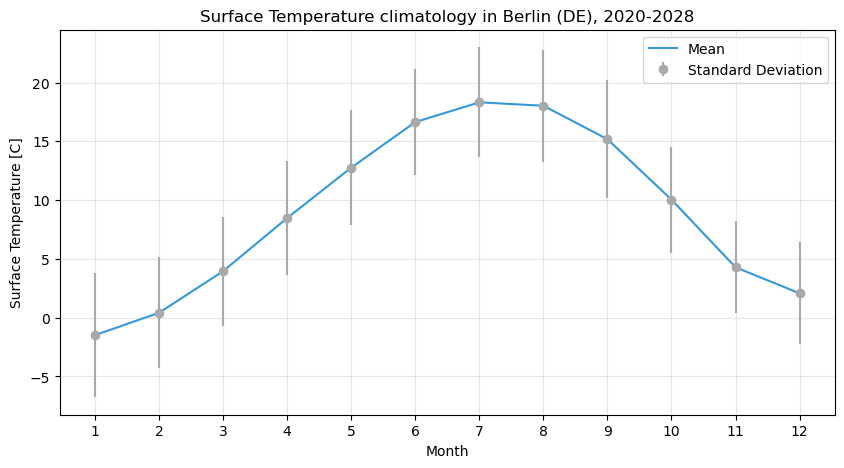

In [11]:
plt.figure(figsize=(10, 5))
t2m_Berlin_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_Berlin_climatology_mean.month, 
    t2m_Berlin_climatology_mean, 
    yerr=t2m_Berlin_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)

plt.title("Surface Temperature climatology in Berlin (DE), 2020-2028")
plt.xticks(t2m_Berlin_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()